<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
raw_df = pd.read_csv('drive/MyDrive/ML/train.csv')
raw_df.drop(columns=['Surname','id','CustomerId'], inplace=True)

In [ ]:
train_df, val_df = split_train_val(raw_df, 'Exited')

In [ ]:
inputs = raw_df.columns.difference(['Exited'])

In [ ]:
inputs

Index(['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Gender',
       'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure'],
      dtype='object')

In [ ]:
X_train, y_train = separate_inputs_targets(train_df, inputs, 'Exited' )
X_val, y_val = separate_inputs_targets(val_df, inputs, 'Exited' )

In [ ]:
X_train

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure
7180,30.0,131394.56,682.0,143952.24,Male,France,1.0,1.0,1.0,1.0
10393,39.0,178058.06,684.0,145518.31,Female,France,1.0,0.0,1.0,2.0
80,35.0,116320.68,705.0,174431.01,Male,Germany,1.0,0.0,2.0,6.0
3365,58.0,0.00,669.0,51565.98,Male,Spain,0.0,1.0,2.0,0.0
12236,21.0,0.00,707.0,148564.76,Male,France,1.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
9493,33.0,0.00,633.0,123537.05,Female,France,0.0,0.0,2.0,4.0
8463,40.0,0.00,673.0,47832.82,Female,France,1.0,1.0,1.0,1.0
8143,29.0,0.00,621.0,133535.29,Male,France,1.0,1.0,2.0,8.0
11512,42.0,0.00,590.0,72643.95,Male,Spain,0.0,0.0,2.0,7.0


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [ ]:
categorical_cols = raw_df.select_dtypes('object').columns
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_val[categorical_cols] = X_val[categorical_cols].astype('category')

In [ ]:
X_train.dtypes

,0
Age,float64
Balance,float64
CreditScore,float64
EstimatedSalary,float64
Gender,category
Geography,category
HasCrCard,float64
IsActiveMember,float64
NumOfProducts,float64
Tenure,float64


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [ ]:
!conda install -c conda-forge xgboost

/bin/bash: line 1: conda: command not found


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, f1_score, accuracy_score)

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda'
)

In [ ]:
xgb_clf.fit(X_train, y_train)

train_pred = xgb_clf.predict_proba(X_train)[:,1]
val_pred = xgb_clf.predict_proba(X_val)[:,1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:41] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:41] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
def plot_roc_auc(prediction,targets, df):
  fpr, tpr, thresholds = roc_curve(targets,  prediction)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {df} data')
  plt.legend(loc="lower right")
  plt.show()
  accuracy = accuracy_score(targets, (prediction > 0.5).astype(int))
  print(f'Accuracy score for {df} data: {accuracy}')

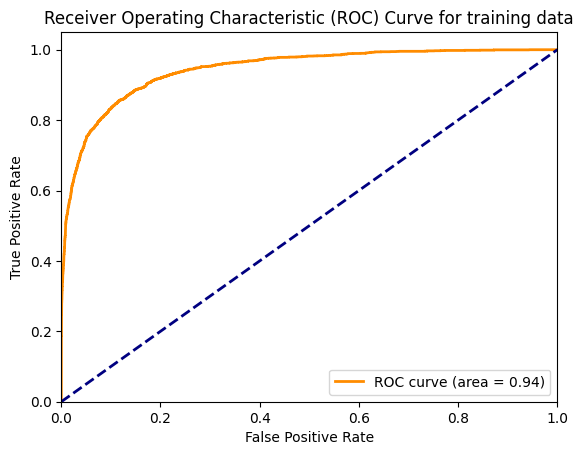

Accuracy score for training data: 0.90775


In [ ]:
plot_roc_auc(train_pred, y_train, 'training')

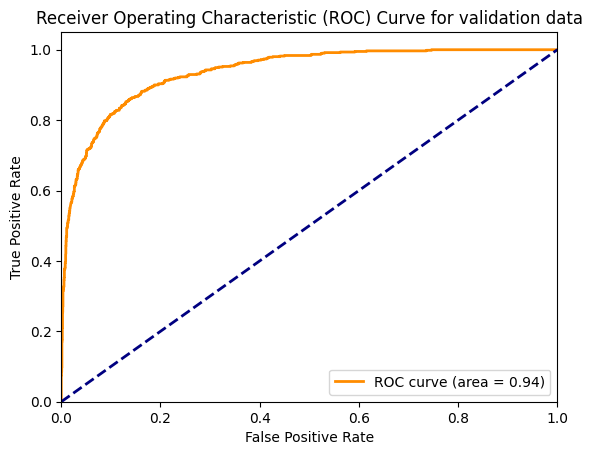

Accuracy score for validation data: 0.901


In [ ]:
plot_roc_auc(val_pred, y_val, 'validation')

В цілому модель показала значно кращий результат, ніж модель DecisionTrees - значення AUROC вище і різниця між тренувальними та валідаційними даними значно менша.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [ ]:
!pip install hyperopt

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']), # Кількість дерев
        learning_rate=params['learning_rate'], # Швидкість навчання
        max_depth=int(params['max_depth']), # Максимальна глибина дерев
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,  # Дозволяє використовувати категоріальні ознаки
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10, # Раннє зупинення, якщо результат не покращується 10 ітерацій
        scale_pos_weight=params.get('scale_pos_weight', 1), # Балансування класів
        max_bin=int(params.get('max_bin', 256)),
        random_state=42,  # Встановлення випадкового стану
        n_jobs=-1  # Використання всіх доступних процесорів
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
    pred = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val,  pred)
    roc_auc = auc(fpr, tpr)


    return {'loss': - roc_auc, 'status': STATUS_OK}

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
}

In [ ]:
# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['scale_pos_weight'] = int(best['scale_pos_weight'])
best['max_bin'] = int(best['max_bin'])

print("Найкращі гіперпараметри: ", best)

  5%|▌         | 1/20 [00:00<00:04,  4.66trial/s, best loss: -0.9346944234858359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 2/20 [00:00<00:04,  4.23trial/s, best loss: -0.9346944234858359]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 20%|██        | 4/20 [00:00<00:02,  6.15trial/s, best loss: -0.9349495850195487]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 35%|███▌      | 7/20 [00:01<00:01,  7.79trial/s, best loss: -0.9351972014541465]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 40%|████      | 8/20 [00:01<00:01,  8.17trial/s, best loss: -0.9361883531106385]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 50%|█████     | 10/20 [00:01<00:01,  7.95trial/s, best loss: -0.9361883531106385]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 60%|██████    | 12/20 [00:01<00:00,  8.17trial/s, best loss: -0.9361883531106385]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 75%|███████▌  | 15/20 [00:02<00:00,  8.16trial/s, best loss: -0.9368629535633446]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 80%|████████  | 16/20 [00:02<00:00,  8.31trial/s, best loss: -0.9368629535633446]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 90%|█████████ | 18/20 [00:02<00:00,  6.69trial/s, best loss: -0.9368629535633446]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:02<00:00,  7.37trial/s, best loss: -0.9368629535633446]
Найкращі гіперпараметри:  {'colsample_bytree': 0.8764399438584467, 'gamma': 0.07530333009561224, 'learning_rate': 0.15922514922977926, 'max_bin': 208, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 50, 'reg_alpha': 0.5733860202938901, 'reg_lambda': 0.066790898300364, 'scale_pos_weight': 4, 'subsample': 0.9308256611852541}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:56] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

In [ ]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    scale_pos_weight=best['scale_pos_weight'],
    max_bin=best['max_bin'],
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, y_train)
final_pred_train = final_clf.predict_proba(X_train)[:,1]
final_pred_val = final_clf.predict_proba(X_val)[:,1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


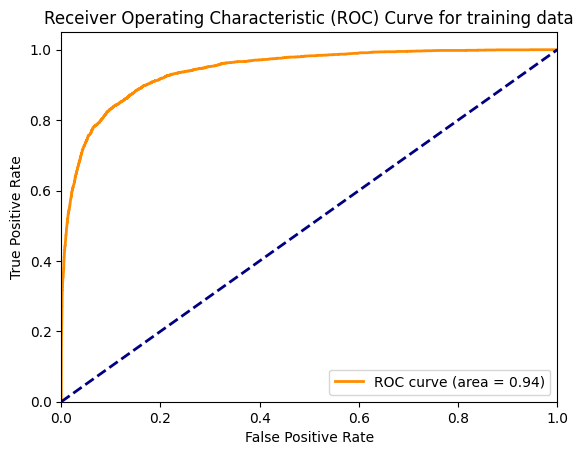

Accuracy score for training data: 0.8701666666666666


In [ ]:
plot_roc_auc(final_pred_train, y_train, 'training')

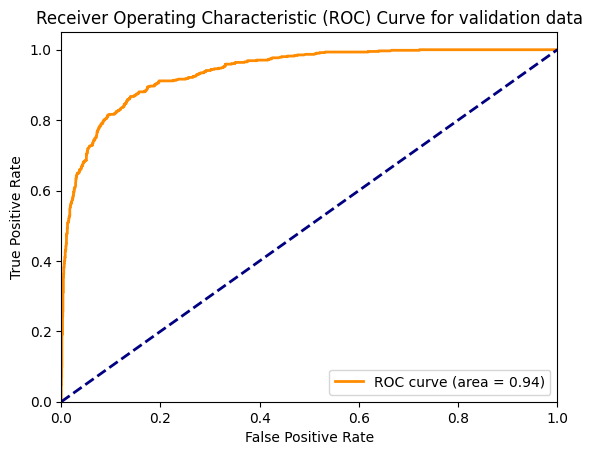

Accuracy score for validation data: 0.8623333333333333


In [ ]:
plot_roc_auc(final_pred_val, y_val, 'validation')

Не можу сказати, що дана модель набагато краща , ніж попередня: вона дала майже такі ж самі результати, що і попередня.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [ ]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,610 kB]
Get:13 http://archive.ubuntu.com/ubuntu ja

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-libopencl1 is already the newest version (2.2.14-3).
ocl-icd-libopencl1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
nvidia-opencl-dev is already the newest version (11.5.1-1ubuntu1).
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (10.5 kB/s)
Selecting previously unselected package opencl-headers.
(Reading database ... 125788 files and directories currently installed.)
Preparing to unpack .../opencl-headers_3.0~20

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

Process is interrupted.


In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in categorical_cols]

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
    missing=np.nan,
    # device='cuda'  # використовувати GPU для прискорення обчислень
)

lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

train_pred_lgb = lgb_clf.predict_proba(X_train)[:,1]
val_pred_lgb = lgb_clf.predict_proba(X_val)[:,1]


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=5,4, categorical_column=4,5 will be ignored. Current value: categorical_feature=5,4
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

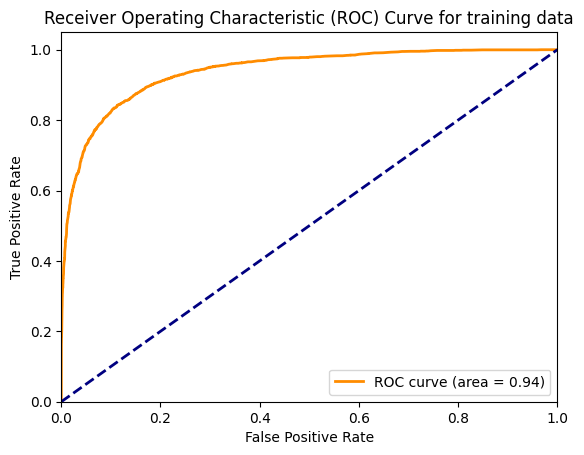

Accuracy score for training data: 0.9025


In [ ]:
plot_roc_auc(train_pred_lgb, y_train, 'training')

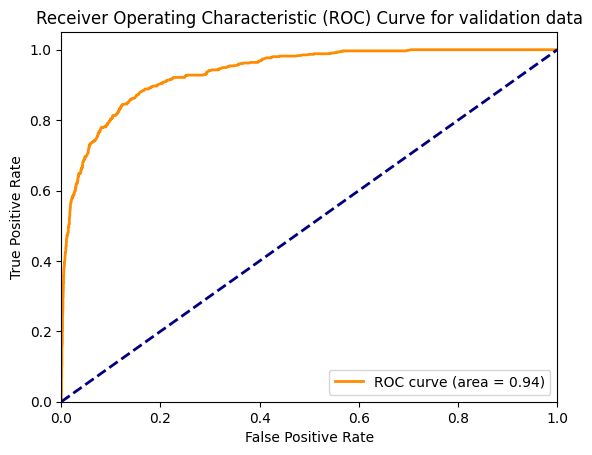

Accuracy score for validation data: 0.8986666666666666


In [ ]:
plot_roc_auc(val_pred_lgb, y_val, 'validation')

В цілому модель непогана, перенавчання чи недонавчання не спостерігаю. Значення AUROC досить високе і різниця значень між тренувальними та валідаційними даними невелика. Але дана модель у порівнянні з XGBoostClassifier не покращила результати класифікації.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    pred = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val,  pred)
    roc_auc = auc(fpr, tpr)

    return {'loss': - roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

[LightGBM] [Warning] categorical_feature is set with cat_feature=5,4, categorical_column=4,5 will be ignored. Current value: categorical_feature=5,4
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_clf_lgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])
final_pred_train_lgb = final_clf_lgb.predict_proba(X_train)[:,1]
final_pred_val_lgb = final_clf_lgb.predict_proba(X_val)[:,1]

[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=5,4, categorical_column=4,5 will be ignored. Current value: categorical_feature=5,4
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

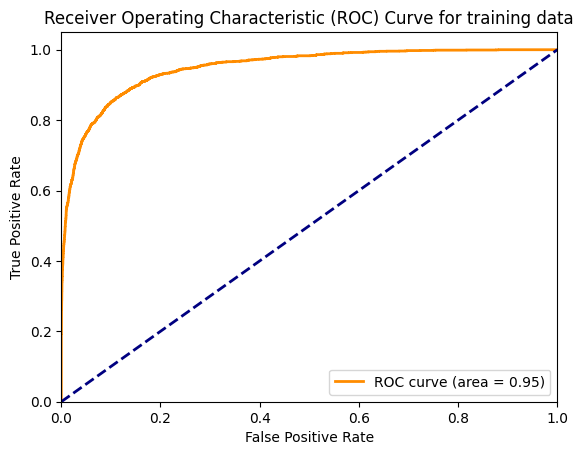

Accuracy score for training data: 0.9124166666666667


In [ ]:
plot_roc_auc(final_pred_train_lgb, y_train, 'training')

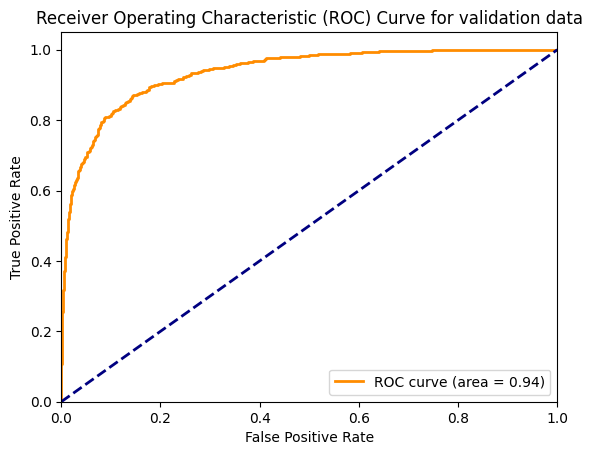

Accuracy score for validation data: 0.9003333333333333


In [ ]:
plot_roc_auc(final_pred_val_lgb, y_val, 'validation')

Значення AUROC і на тренувальних, та валідаційних даних високе, але є різниця між ними. Модель XGBoostClassifier показала більш стабільний результат.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [ ]:
X_test = pd.read_csv('drive/MyDrive/ML/test.csv')
X_test.drop(columns=['Surname','id','CustomerId'], inplace=True)
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

In [ ]:
X_test.dtypes

,0
CreditScore,float64
Geography,category
Gender,category
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64
EstimatedSalary,float64


In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
X_test.head()

,Age,Balance,CreditScore,EstimatedSalary,Gender,Geography,HasCrCard,IsActiveMember,NumOfProducts,Tenure,Exited
0,30.0,146053.66,584.0,157891.86,Male,Germany,1.0,1.0,1.0,2.0,0.078353
1,39.0,0.00,551.0,67431.28,Male,France,1.0,1.0,2.0,5.0,0.016212
2,43.0,0.00,706.0,156768.45,Male,France,1.0,0.0,2.0,8.0,0.060441
3,45.0,0.00,717.0,166909.87,Male,Spain,1.0,1.0,1.0,3.0,0.518758
4,43.0,0.00,592.0,143681.97,Male,Spain,1.0,1.0,2.0,8.0,0.030705


In [ ]:
submission_file = pd.read_csv('drive/MyDrive/ML/sample_submission.csv')
X_test['Exited'] = final_clf.predict_proba(X_test)[:,1]
submission_file['Exited'] = X_test['Exited']
submission_file.head()

,id,Exited
0,15000,0.254654
1,15001,0.053993
2,15002,0.225072
3,15003,0.807185
4,15004,0.118879


In [ ]:
file_path = '/content/drive/MyDrive/ML/submission_xgboost.csv'
submission_file.to_csv(file_path, index=False)

Обрала саме модель xgboost, бо вона надала найбільш стабільше значення AUROC - різниця між валідаційними та тренувальними даними дуже мала.

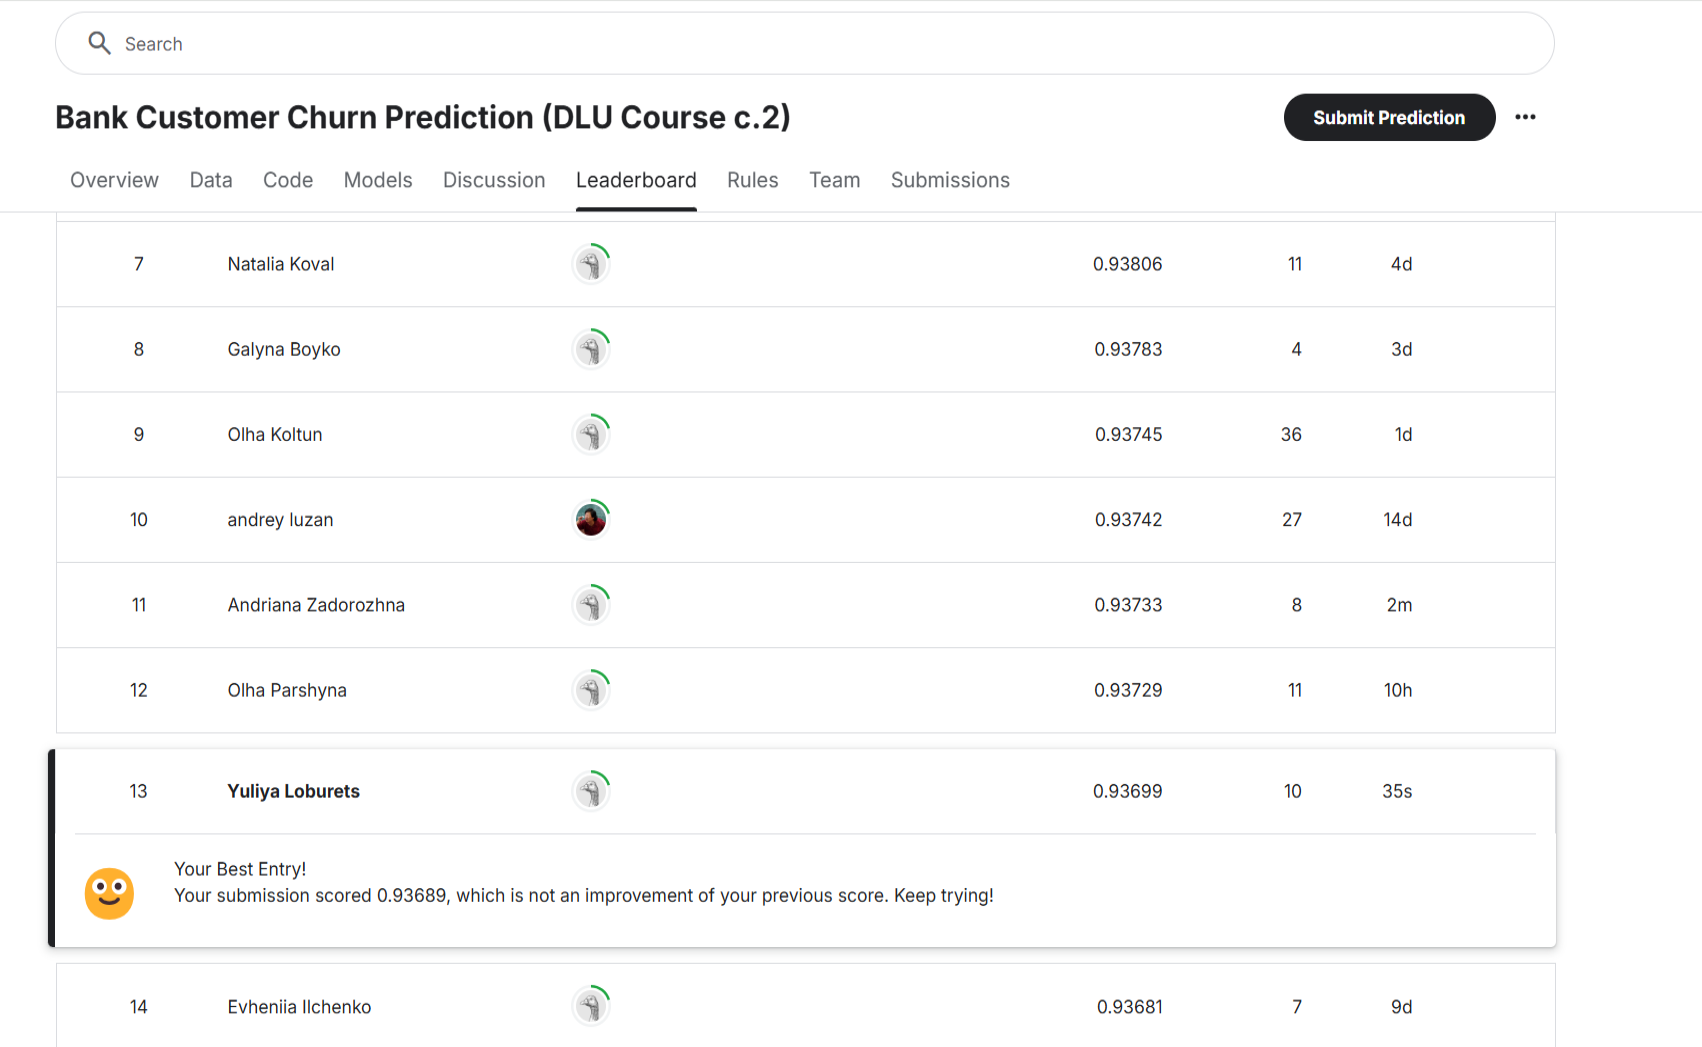

In [ ]:
from IPython.display import Image, display
img_path = "/content/drive/My Drive/ML/xgboost.png"
display(Image(img_path))